In [ ]:
!pip install -U tensorflow

In [ ]:
!pip install -U keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.applications.mobilenet_v2 import MobileNetV2
import time
import math


In [ ]:
img_height, img_width = 224, 224
batch_size = 32

# Added data augmentation to the training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/color_dataset/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical', #makes 10 ordered vectors ex bmw[1,0,0]
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/color_dataset/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2886 images belonging to 9 classes.
Found 664 images belonging to 9 classes.


In [ ]:
from tensorflow.keras import mixed_precision

# telling TensorFlow to use float16 data type for certain operations during training
policy = mixed_precision.Policy('mixed_float16') 
mixed_precision.set_global_policy(policy)

#using pretrained model base, so take off top layers 
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)) #3-rgb

x = base_model.output
x = GlobalAveragePooling2D()(x) #reduces # parameters but focus on spatial relationships
x = Dense(1024, activation='relu')(x) #relu introduces nonlinearity(patterns), helps learn complexity

predictions = Dense(9, activation='softmax', dtype='float32')(x) 
#adding new layer, dense=neuron connected to neuron in prev layers
#10 outp units(10 models)
#softmax connects outputs to probability
#float32 default outp for keras

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False #not training base model, only additions

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#categorical_crossentropy helps measure loss aka difference between images

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

lrate_scheduler = LearningRateScheduler(step_decay)


9406464/9406464 [==============================] - 2s 0us/step


In [ ]:
train_steps = len(train_generator) #returns length aka steps
validation_steps = len(validation_generator)

start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=validation_steps
)
elapsed_time = time.time() - start_time
print(f"Elapsed time for one epoch: {elapsed_time:.2f} seconds")


In [ ]:
num_epochs = 100
checkpoint_frequency = 5

checkpoint_callback = ModelCheckpoint(
    filepath='vehicle_color_classifier_epoch_{epoch:02d}.h5',
    save_freq=checkpoint_frequency * train_steps,
    save_best_only=False
)

# Added the learning rate scheduler to the callbacks list
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback, lrate_scheduler]
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

cmodel_path = '/content/drive/MyDrive/color.h5'
cmodel = load_model(cmodel_path)


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

path_to_color_validate = '/content/drive/MyDrive/color_dataset/test'

# Define an ImageDataGenerator to normalize the images
image_generator = ImageDataGenerator(rescale=1./255)

# Load the images from the 'cars_validate' folder
validation_generator = image_generator.flow_from_directory(
    path_to_color_validate,
    target_size=(224, 224),  # Assuming the model was trained with 224x224 images
    batch_size=10,
    class_mode='categorical',
    shuffle=False
)


class_names = list(validation_generator.class_indices.keys())
print("Class names in the order they were used during training:", class_names)


Found 664 images belonging to 9 classes.
Class names in the order they were used during training: ['black', 'blue', 'brown', 'green', 'pink', 'red', 'silver', 'white', 'yellow']


1/1 [==============================] - 0s 24ms/step


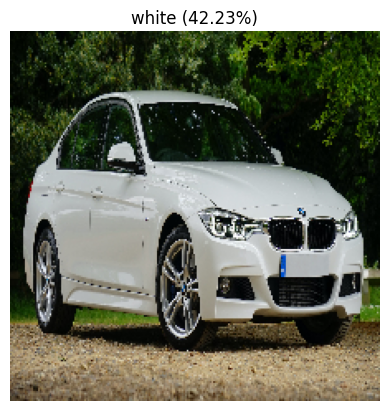

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


input_image_file_path = "whitecar.jpg"

# Load the input image and resize it to the target size (224, 224)
input_img = load_img(input_image_file_path, target_size=(224, 224))

# Convert the input image to a NumPy array and normalize the pixel values
input_img_array = img_to_array(input_img) / 255.0

# Add an extra dimension to match the model's input shape (1, 224, 224, 3) 3 is rgb, 1 is batch size
input_img_expanded = np.expand_dims(input_img_array, axis=0)

# Make a prediction using the preprocessed input image
prediction = model.predict(input_img_expanded)

# Convert the prediction into a class index/array, gives a number for highest prob class
predicted_class_index = np.argmax(prediction, axis=1)[0]

# Extract the confidence value (probability) for the predicted class
predicted_class_confidence = prediction[0][predicted_class_index] * 100

# Map the predicted class index back to the class name
predicted_class_name = class_names[predicted_class_index]

# Revert the normalization for displaying the image
input_img_array_display = input_img_array * 255.0

# Display the input image along with the predicted class name and confidence value
plt.imshow(input_img_array_display.astype(np.uint8))
plt.title(f"{predicted_class_name} ({predicted_class_confidence:.2f}%)")
plt.axis("off")
plt.show()

In [ ]:
import numpy as np

# Make predictions on the validation set
predictions = model.predict(validation_generator)

# Convert the predictions into class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Map the predicted class indices back to the class names
predicted_class_names = [class_names[i] for i in predicted_class_indices]

true_labels = validation_generator.labels
true_class_names = [class_names[i] for i in true_labels]

for i, (true_class_name, predicted_class_name) in enumerate(zip(true_class_names, predicted_class_names)):
    print(f"Image {i+1}: True class: {true_class_name}, Predicted class: {predicted_class_name}")

# Calculate the overall accuracy
accuracy = np.mean(predicted_class_indices == true_labels) * 100
print(f"\nOverall accuracy: {accuracy:.2f}%")


In [ ]:
import shutil

shutil.make_archive("10decaycolor", "zip", "download")

'/content/10decaycolor.zip'